As part of this assignment, try leveraging Naïve Bayes as a model for your independent project. As part of the modeling process, you might need to convert the data into categorical form to apply Naïve Bayes.

As a hint, if you have numerical attributes, use binning to convert them to categorical.

Instructions

Please complete the lab exercise for this week before following these steps to complete your assignment.

- Leverage Naïve Bayes algorithm to classify build a model using the data from previous milestones.
- Briefly summarize your findings on using Naïve Bayes.
- Is Naïve Bayes more accurate than the regression model you used in Milestone 3?

To submit your assignment

- Save your file as Studentname-M02-L09-BayesOpEd.ipynb, using your own name rather than Studentname.
- Submit your assignment on the next page.


In [1]:
#Loading libraries
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

In [2]:
#Load File
filename = 'kc_house_data.csv'
house_df = pd.read_csv(filename)

## Data cleaning:

**Since in previous analysis (Milestone 1) it was already presented the *first look to the data* an some reasoning on why the data was filtered in certain way, in this section of the analysis it would be assumed as already covered and understood.**

In [3]:
#Removing outliers based on Price:
LimitHi = np.mean(house_df['price']) + 1*np.std(house_df['price']) #Higher Limit for each of the numeric attributes
LimitLo = np.mean(house_df['price']) - 1*np.std(house_df['price']) #Lower Limit for each of the numeric attributes
FlagBad = (house_df['price'] < LimitLo) | (house_df['price'] > LimitHi) #Boolean for values outside limits
FlagGood = ~FlagBad #Complement
house_df = house_df.loc[FlagGood]

#Some cleaning of the data (outliers) will be removed since we are interested in the typical market for the region.
FlagBad = (house_df['bedrooms'] > 8) #Boolean for values outside limits
FlagGood = ~FlagBad #Complement
house_df = house_df.loc[FlagGood] 

FlagBad = (house_df['bathrooms'] > 6) #Boolean for values outside limits
FlagGood = ~FlagBad #Complement
house_df = house_df.loc[FlagGood] 

FlagBad = (house_df['sqft_lot'] > 50000) #Boolean for values outside limits
FlagGood = ~FlagBad #Complement
house_df = house_df.loc[FlagGood] 

house_df = house_df.dropna()

#Transforming the variable date into DateTime Variable
house_df.loc[:, 'date'] = pd.to_datetime(house_df.loc[:, 'date'])
#house_df.set_index('date', inplace = True)

#Column price from str to numeric (int64)
house_df['price'] = pd.to_numeric(house_df['price'])

#Creating a variable called `price_log`
#house_df['price_log'] = np.log(house_df['price'])

### `Price` Distribution

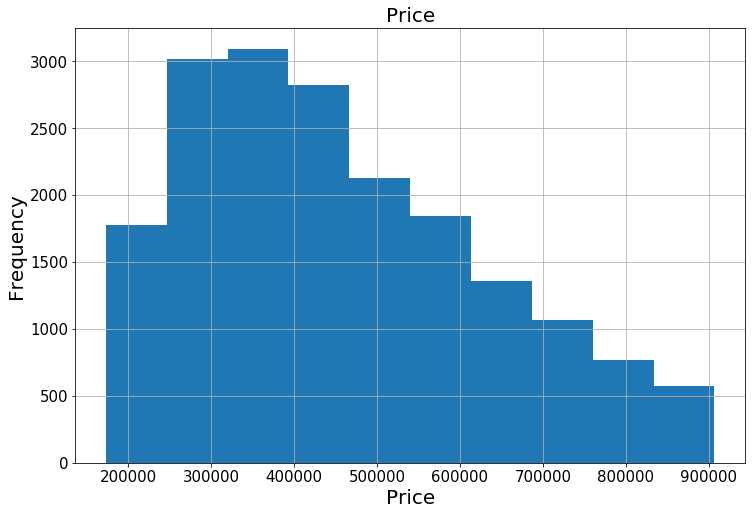

In [4]:
house_df['price'].hist(figsize = (12,8))
plt.xlabel('Price', fontsize = 20)
plt.ylabel('Frequency',fontsize = 20)
plt.title('Price', fontsize = 20)
plt.tick_params(axis="x", labelsize=15)
plt.tick_params(axis="y", labelsize=15)
plt.grid(True)
plt.show()

As it can be seen the avg `price` of a house in this sample is around ~$380,000 (after outliers were removed).

In [5]:
house_df2 = house_df.copy()
house_df2.index = house_df2['date']

In [6]:
house_df.dtypes

id                        int64
date             datetime64[ns]
price                   float64
bedrooms                  int64
bathrooms               float64
sqft_living               int64
sqft_lot                  int64
floors                  float64
waterfront                int64
view                      int64
condition                 int64
grade                     int64
sqft_above                int64
sqft_basement             int64
yr_built                  int64
yr_renovated              int64
zipcode                   int64
lat                     float64
long                    float64
sqft_living15             int64
sqft_lot15                int64
dtype: object

In [7]:
house_df.shape

(18459, 21)

## `Price` Time Distribution

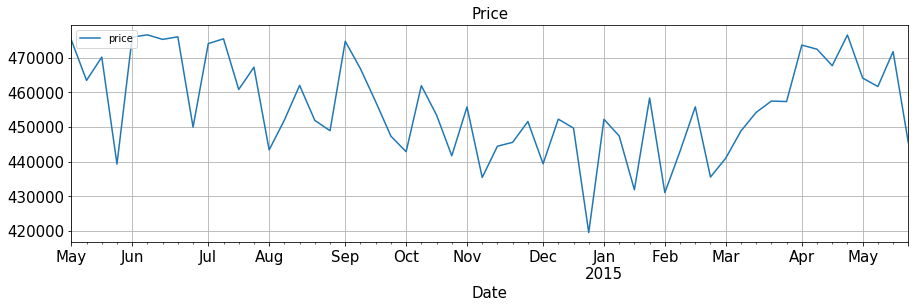

In [8]:
#Time series plot for Price
#To minimize the noise each data point seen here is the mean of a 2 Weeks sample
house_df2[["price"]].resample("1W").mean().plot(figsize=(15,4))
plt.tick_params(axis="x", labelsize=15)
plt.tick_params(axis="y", labelsize=15)
plt.xlabel('Date', fontsize = 15)
plt.title('Price',fontsize=15)
plt.legend(loc='upper left', fontsize=10)
plt.grid(True)

## Exploration of dataset

In the previous analysis (Milestone 01) it was shown that some of the variables (attributes) in the data set do not add value to predict the `price` of a house. For tha reason those columns were removed from this analysis and are not going to be covered in here.

The variables that will be explore are:

- `price`
- `sqft_living`
- `bedrooms`
- `bathrooms`
- `floors`
- `view`
- `condition`
- `grade`

For simplicity in this analysis categorical variables or variables were values are discrete will be bin into either 2 or 3 categories as needed.

## Basic statistics by both Classic boostrap & Bayesian Model

- For this point forward only the `price_log` variable will be analyzed since that is the one of most interest for the costumer.


- Some variables are going to be divided (bin) into small groups to be able to compared distributions:
   - `condition`
   - `grade`
   - `bedrooms`
   - `bathrooms`
  
 
 - In the previous Milestone (01) we saw that the following 2 factors do not contribute much to determine the price of a house, therefore are not going to be explored in this analysis:
  - `view`
  - `floors`

In [9]:
house_df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,2014-10-13,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,2014-12-09,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,2015-02-25,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,2014-12-09,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,2015-02-18,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


### Reducing Features
We can see some features which are likely to be collinear. The code in the cell below removes these columns. Execute this code to create a data set with reduced features.

In [10]:
categorical = ['bedrooms','bathrooms','sqft_living','condition','grade']
#first we need to ensure the variables are numeric
for i in categorical:
    house_df.loc[:, i] = house_df[i].astype(int)

In [11]:
house_df.dtypes

id                        int64
date             datetime64[ns]
price                   float64
bedrooms                  int32
bathrooms                 int32
sqft_living               int32
sqft_lot                  int64
floors                  float64
waterfront                int64
view                      int64
condition                 int32
grade                     int32
sqft_above                int64
sqft_basement             int64
yr_built                  int64
yr_renovated              int64
zipcode                   int64
lat                     float64
long                    float64
sqft_living15             int64
sqft_lot15                int64
dtype: object

## Should I used the months as a variable?

In [12]:
#house_df.dtypes

In [13]:
#Creating bin variables to split the distribution
house_df['condition_binned'] = pd.cut(x=house_df['condition'], bins=[0,3,6], labels = [0, 1])
house_df['grade_binned'] = pd.cut(x=house_df['grade'], bins=[0,6,13], labels = [0, 1])
house_df['bedrooms_binned'] = pd.cut(x=house_df['bedrooms'], bins=[0,3,9], labels = [0, 1])
house_df['bathrooms_binned'] = pd.cut(x=house_df['bathrooms'], bins=[0,2,4,8], labels = [0, 1, 2])
house_df['sqft_living_binned'] = pd.cut(x=house_df['sqft_living'], bins=[0,1500,2500,8000], labels = [0, 1, 2])
house_df['price_binned'] = pd.cut(x=house_df['price'], bins=[0,350000,600000,1000000], labels = [0, 1, 2])

In [14]:
# house_df['Month'] = house_df['date'].dt.strftime('%b')
# ##Create dummy variables for the months
# unique_years = house_df['date'].dt.strftime('%Y').unique()
# dummies = pd.get_dummies(house_df.loc[:, 'Month'])
# house_df[list(dummies.columns)] = dummies

In [15]:
house_df = house_df.dropna()

In [16]:
#house_df2['condition'].unique()
#house_df = house_df.drop(['bathrooms_binned','condition_binned','grade_binned','bedrooms_binned','bathrooms','sqft_living','price','id','date', 'sqft_lot', 'floors', 'waterfront', 'view', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long', 'sqft_living15', 'sqft_lot15','sqft_above'], axis=1)
house_df = house_df.drop(['condition_binned','grade_binned','bedrooms_binned','bathrooms','sqft_living','price','id','date', 'sqft_lot', 'floors', 'waterfront', 'view', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long', 'sqft_living15', 'sqft_lot15','sqft_above'], axis=1)

In [17]:
#house_df = house_df.drop(['grade','bedrooms','bathrooms','sqft_living','condition','Month','price','id','date', 'sqft_lot', 'floors', 'waterfront', 'view', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long', 'sqft_living15', 'sqft_lot15','sqft_above'], axis=1)
#house_df = house_df.drop(['grade','bedrooms','bathrooms','sqft_living','condition','price','id','date', 'sqft_lot', 'floors', 'waterfront', 'view', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long', 'sqft_living15', 'sqft_lot15','sqft_above'], axis=1)
#house_df.head()

In [18]:
house_df.dtypes

bedrooms                 int32
condition                int32
grade                    int32
bathrooms_binned      category
sqft_living_binned    category
price_binned          category
dtype: object

In [19]:
# for i in house_df.columns:
#     if house_df[i].dtype == 'uint8':
#         house_df[i] = house_df[i].astype(pd.api.types.CategoricalDtype())

In [20]:
label_col = 'price_binned'

labels = house_df[label_col].cat.codes

#features = house_df[['condition_binned', 'grade_binned','price_binned','bathrooms_binned','sqft_living_binned']]
#features = house_df[['condition', 'grade','bedrooms','bathrooms_binned','sqft_living_binned']]
#features = house_df[['condition', 'grade','bedrooms','sqft_living_binned']]

# categorical = ['condition_binned', 'grade_binned','price_binned','bathrooms_binned','sqft_living_binned']
# #first we need to ensure the variables are numeric
# for i in categorical:
#     house_df.loc[:, i] = house_df[i].astype(int)
    
features = []
for c in house_df.columns:
    if c != label_col:
        if str(house_df[c].dtype) == 'category':
            features.append(house_df[c].cat.codes)
        else:
            features.append(house_df[c])

In [21]:
#features

In [22]:
#house_df = house_df.dropna()
house_df.dtypes

bedrooms                 int32
condition                int32
grade                    int32
bathrooms_binned      category
sqft_living_binned    category
price_binned          category
dtype: object

In [23]:
feature_vecs = np.array(features).T

In [24]:
feature_vecs

array([[3, 3, 7, 0, 0],
       [3, 3, 7, 0, 2],
       [2, 3, 6, 0, 0],
       ...,
       [3, 3, 8, 0, 1],
       [4, 3, 8, 0, 1],
       [3, 3, 8, 0, 1]])

In [25]:
import sklearn.metrics
import sklearn.naive_bayes

In [26]:
# Create the Model
model = sklearn.naive_bayes.MultinomialNB(alpha=1e-7)

In [27]:
model.fit(feature_vecs, labels)

MultinomialNB(alpha=1e-07)

In [28]:
conditional_probas = pd.DataFrame(model.feature_log_prob_, columns=house_df.columns[:-1])
conditional_probas

,bedrooms,condition,grade,bathrooms_binned,sqft_living_binned
0,-1.504299,-1.414639,-0.702989,-6.372295,-3.270103
1,-1.521482,-1.499378,-0.703310,-5.344201,-2.836633
2,-1.533246,-1.591216,-0.719982,-4.575654,-2.483773


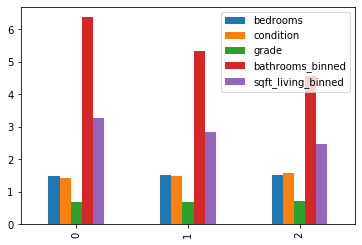

In [29]:
(-conditional_probas).plot(kind= 'bar')

In [30]:
# Replace ??? with the correct parameters
predicted_price = model.predict(feature_vecs)
price_probabilities = model.predict_proba(feature_vecs)

In [31]:
accuracy = sklearn.metrics.accuracy_score(labels, predicted_price)

In [32]:
precision = sklearn.metrics.precision_score(labels, predicted_price,average='macro')

In [33]:
recall = sklearn.metrics.recall_score(labels, predicted_price, average='macro')

In [34]:
print('Accuracy = %.3f, Precision = %.3f, Recall = %.3f' % (accuracy, precision, recall))
print('Confusion matrix:')

Accuracy = 0.501, Precision = 0.548, Recall = 0.438
Confusion matrix:


In [35]:
import sklearn.metrics

def confusion_matrix(labels, predicted_labels, label_classes):
    return pd.DataFrame(
        sklearn.metrics.confusion_matrix(labels, predicted_labels),
        index=[label_classes], 
        columns=label_classes)    

In [36]:
confusion_matrix(labels, predicted_price, 
                 house_df[label_col].cat.categories)

,0,1,2
0,3086,3144,33
1,2273,5578,294
2,271,3167,547


In [37]:
def performance(results):
    accuracy = sklearn.metrics.accuracy_score(
        results['party'].cat.codes, results['predicted'].cat.codes)
    precision = sklearn.metrics.precision_score(
            results['party'].cat.codes, results['predicted'].cat.codes)
    recall = sklearn.metrics.recall_score(
            results['party'].cat.codes, results['predicted'].cat.codes)

    print('Accuracy = %.3f, Precision = %.3f, Recall = %.3f' % (accuracy, precision, recall))
    
    return confusion_matrix(
        results['party'], 
        results['predicted'], 
        results.party.cat.categories)

In [38]:
performance(results)

NameError: name 'results' is not defined